Original notebook: https://colab.research.google.com/drive/1FOczd5Gq9NSvEcosZcpTCWltEgN9q6X1?usp=sharing#scrollTo=70aae7d57446dca3

## Data Preparation

### Import Libraries

In [29]:
import pandas as pd
import plotly.express as px
from geopy.geocoders import Nominatim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# ignore pandas warning
import warnings

warnings.filterwarnings("ignore")

### Load Data

First we get the data in regards to health facilities in Kenya.    
We will remane the district to sub-county in the dataset since districts were renamed to subcounties.

In [30]:
health_facilities_df = pd.read_excel("https://github.com/tony-nyagah/data-monday/raw/main/healthcare-datathon/data/health-facilities-data-kenya.xlsx")
# rename district to sub county
health_facilities_df = health_facilities_df.rename(columns={"District": "Sub County"})
health_facilities_df.head(5)

,Facility Code,Facility Name,Province,County,Sub County,Division,Type,Owner,Location,Sub Location,...,IPD,OPD,OUTREACH,PMTCT,RAD/XRAY,RHTC/RHDC,TB DIAG,TB LABS,TB TREAT,YOUTH
0,19224,CDF Kiriari Dispensary,Eastern,Embu,Manyatta,Manyatta,Dispensary,Ministry of Health,Ruguru,Ruguru,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19310,St Jude's Huruma Community Health Services,Nairobi,Nairobi,Mathare,Huruma,Medical Clinic,Private Practice - Unspecified,Huruma,Huruma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14180,10 Engineer VCT,Rift Valley,Laikipia,Laikipia East,Central,Dispensary,Armed Forces,Nanyuki,Majengo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,17486,12 Engineers,Central,Kiambu,Thika West,NaN,Dispensary,Ministry of Health,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18393,3Kl Maternity & Nursing Home,Rift Valley,Kajiado,Kajiado North,Ongata Rongai,Nursing Home,Private Practice - Clinical Officer,Gataka,Gataka,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Our  main county of focus will be Nairobi so we're going to focus on data in Nairobi.    

In [31]:
health_facilities_df_nairobi = health_facilities_df[
    health_facilities_df["County"] == "Nairobi"
]

health_facilities_df_nairobi.head(5)

,Facility Code,Facility Name,Province,County,Sub County,Division,Type,Owner,Location,Sub Location,...,IPD,OPD,OUTREACH,PMTCT,RAD/XRAY,RHTC/RHDC,TB DIAG,TB LABS,TB TREAT,YOUTH
1,19310,St Jude's Huruma Community Health Services,Nairobi,Nairobi,Mathare,Huruma,Medical Clinic,Private Practice - Unspecified,Huruma,Huruma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,13043,7Kr Mrs Health Centre,Nairobi,Nairobi,Langata,Lang'ata,Health Centre,Armed Forces,Mugumoini,Mugumoini,...,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,20346,AAR Adams Health Centre,Nairobi,Nairobi,Kibra,Woodly,Medical Clinic,Private Practice - General Practitioner,Woodly,Woodly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,12861,AAR City Centre Clinic,Nairobi,Nairobi,Starehe,Starehe,Medical Clinic,Private Enterprise (Institution),Central Business District,NaN,...,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,16796,AAR Clinic Sarit Centre (Westlands),Nairobi,Nairobi,Westlands,Parklands,Medical Clinic,Private Enterprise (Institution),Parklands,Upper Parklands,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We then get data on population density by sub-county. This will be used to determine whether facilities are accessible.    
We rename the `National/County` field to `Sub County` since that's the data we'll be targeting.

In [32]:
population_density_by_subcounty_df = pd.read_csv(
    "https://github.com/tony-nyagah/data-monday/raw/main/healthcare-datathon/data/kenya-population-and-area-population-density_by_subcounty.csv"
)
population_density_by_subcounty_df = population_density_by_subcounty_df.rename(
    columns={"National/ County": "Sub County"}
)
population_density_by_subcounty_df.tail(10)

,Sub County,Population,Land Area (Sq. Km),Population Density (No. per Sq. Km)
386,Embakasi,988808,86.3,11460
387,Kamukunji,268276,10.5,25455
388,Kasarani,780656,86.2,9058
389,Kibra .,185777,12.1,15311
390,Lang'ata,197489,216.8,911
391,Makadara,189536,11.7,16150
392,Mathare,206564,3.0,68941
393,Njiru .,626482,129.9,4821
394,Starehe,210423,20.6,10205
395,Westlands,308854,97.5,3167


### Data Cleaning

At a quick glance, the names in the `Sub County` section of the `population_density_by_subcounty_df` dataframe have some inconsistencies.    
We'll remove the trailing spaces and the random `*` and `.` at the end of some sub-county names.    
Since we'll only be dealing with Nairobi county as of now only 'Kibra' sub-county are affected by this, this should be fine.

In [33]:
population_density_by_subcounty_df["Sub County"] = population_density_by_subcounty_df["Sub County"].str.replace("*", "").str.replace(".", "")
population_density_by_subcounty_df.tail(10)

,Sub County,Population,Land Area (Sq. Km),Population Density (No. per Sq. Km)
386,Embakasi,988808,86.3,11460
387,Kamukunji,268276,10.5,25455
388,Kasarani,780656,86.2,9058
389,Kibra,185777,12.1,15311
390,Lang'ata,197489,216.8,911
391,Makadara,189536,11.7,16150
392,Mathare,206564,3.0,68941
393,Njiru,626482,129.9,4821
394,Starehe,210423,20.6,10205
395,Westlands,308854,97.5,3167


The data in `health_facilities_df_nairobi` is pretty clean as is.

### Data Preprocessing

First let's determine how many facilities are in each sub-county in Nairobi.

In [34]:
nairobi_facilities_count = (
    health_facilities_df_nairobi.groupby("Sub County")
    .size()
    .reset_index(name="Number of Facilities")
    .sort_values(by="Number of Facilities", ascending=False)
)
nairobi_facilities_count

,Sub County,Number of Facilities
15,Starehe,136
9,Kibra,93
13,Roysambu,83
0,Dagoretti North,76
16,Westlands,72
10,Langata,61
7,Kamukunji,59
8,Kasarani,58
11,Makadara,55
2,Embakasi Central,44


Since all the Embakasi and Dagoretti sub-counties are counted as one sub-county in the population density dataframe, we'll merge them together.    
The results were edited using Excel.

In [35]:
nairobi_facilities_count = pd.read_csv(
    "https://github.com/tony-nyagah/data-monday/raw/main/healthcare-datathon/data/nairobi-health-facilities-locations.csv"
)
nairobi_facilities_count

,Sub County,Number of Facilities
0,Dagoretti,229
1,Embakasi,351
2,Kamukunji,58
3,Kasarani,55
4,Kibra,44
5,Langata,40
6,Makadara,40
7,Mathare,29
8,Roysambu,27
9,Ruaraka,27


#### Geocode facilities

A good way to check the distribution of facilities is to plot them on a map. This will provide near immediate visual insights into the distribution of facilities.

In [36]:
def get_coordinates(row):
    """This code takes a pandas row and returns a tuple of latitude and longitude.

    Args:
        row (pandas.core.series.Series): pandas row

    Returns:
        tuple: latitude and longitude
    """
    geolocator = Nominatim(user_agent="kenya_healthcare")

    address = f"{row['Sub County']}, Nairobi, Kenya"
    location = geolocator.geocode(address)

    try:
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except:
        return None, None

In [37]:
nairobi_facilities_count[["Latitude", "Longitude"]] = nairobi_facilities_count.apply(
    get_coordinates, axis=1, result_type="expand"
)
nairobi_facilities_count = nairobi_facilities_count.sort_values(
    by="Number of Facilities", ascending=False
)
nairobi_facilities_count

,Sub County,Number of Facilities,Latitude,Longitude
1,Embakasi,351,-1.307610,36.934177
0,Dagoretti,229,-1.283451,36.724673
2,Kamukunji,58,-1.277867,36.861705
3,Kasarani,55,-1.218500,36.902231
4,Kibra,44,-1.306289,36.780783
5,Langata,40,-1.370875,36.818415
6,Makadara,40,-1.295219,36.871861
7,Mathare,29,-1.265011,36.849570
8,Roysambu,27,-1.218840,36.886739
9,Ruaraka,27,-1.242994,36.875619


## Exploratory Data Analysis

### Descriptive Statistics

Here we analyze basic statistics of the health facilities in Nairobi.

In [38]:
print(f"Data shape: {health_facilities_df_nairobi.shape}")
print("-----------------------------")
print(health_facilities_df_nairobi.info())

Data shape: (942, 50)
-----------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 942 entries, 1 to 10496
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Facility Code            942 non-null    int64  
 1   Facility Name            942 non-null    object 
 2   Province                 942 non-null    object 
 3   County                   942 non-null    object 
 4   Sub County               942 non-null    object 
 5   Division                 914 non-null    object 
 6   Type                     942 non-null    object 
 7   Owner                    942 non-null    object 
 8   Location                 894 non-null    object 
 9   Sub Location             672 non-null    object 
 10  Description of Location  641 non-null    object 
 11  Constituency             942 non-null    object 
 12  Nearest Town             824 non-null    object 
 13  Beds                     942 no

We have a total of 942 facilities in Nairobi dataset, the facility code and facility name rows match meaning they are all unique and no null values.

### Data Visualizations

Here we visualize various data in the dataset.

In [39]:
sns.set_style("whitegrid")

Let's look at the number of facilities in each sub-county in Nairobi.

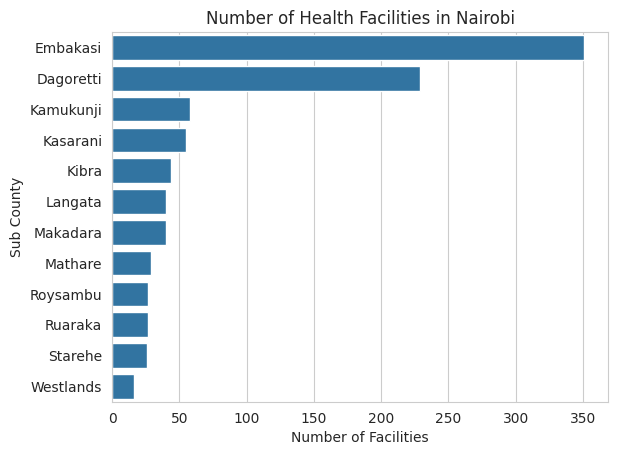

In [40]:
sns.barplot(
    data=nairobi_facilities_count, x="Number of Facilities", y="Sub County", orient="y"
).set_title("Number of Health Facilities in Nairobi");

Now let's view the data on a map.

In [41]:
fig = px.scatter_mapbox(
    data_frame=nairobi_facilities_count,
    lat="Latitude",
    lon="Longitude",
    size="Number of Facilities",
    zoom=10,
    mapbox_style="open-street-map",
    hover_name="Sub County",
)
fig.show()

Embakasi sub-county has the highest number of facilities followed by Dagoretti and least is Westalnds.    
The high number of facilities in said areas is because Dagoretti is separated into North and South and Embakasi is separated into North, South, East and West.

Let's have a look at the facility types in Nairobi.

In [42]:
facility_types = (
    health_facilities_df_nairobi["Type"].value_counts().sort_values(ascending=False)
)

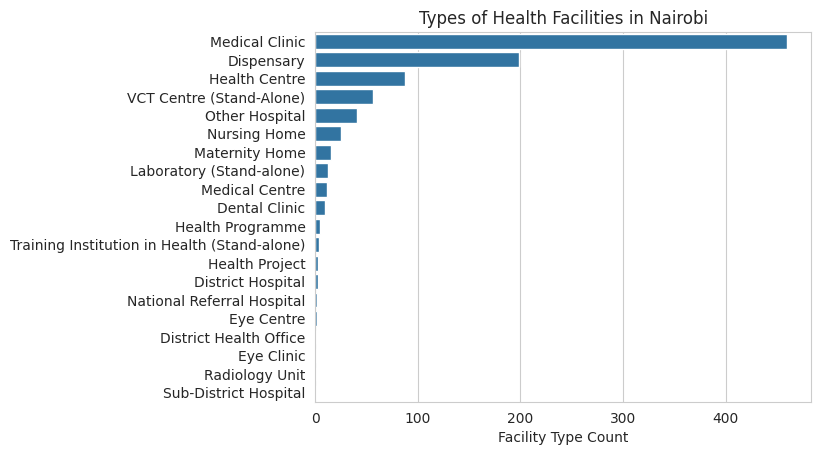

In [43]:
ax = sns.barplot(
    data=pd.DataFrame(facility_types), x=facility_types, y=facility_types.index, orient="y"
).set_title("Types of Health Facilities in Nairobi");
plt.xlabel("Facility Type Count");
plt.ylabel("");

Medical facilities are the most common type of health facility in Nairobi followed by dispensaries.

Let us now look at job titles of those incharge within the health facilities in Nairobi.

In [44]:
job_title_incharge = health_facilities_df_nairobi["Job Title of in Charge"].value_counts()
job_title_incharge

Job Title of in Charge
Nursing Officer in Charge    301
Clinical Officer             135
Hospital Director             61
Doctor In Charge              31
Medical Superintendant        25
Name: count, dtype: int64

A pie chart would be a good way to summarize this data.

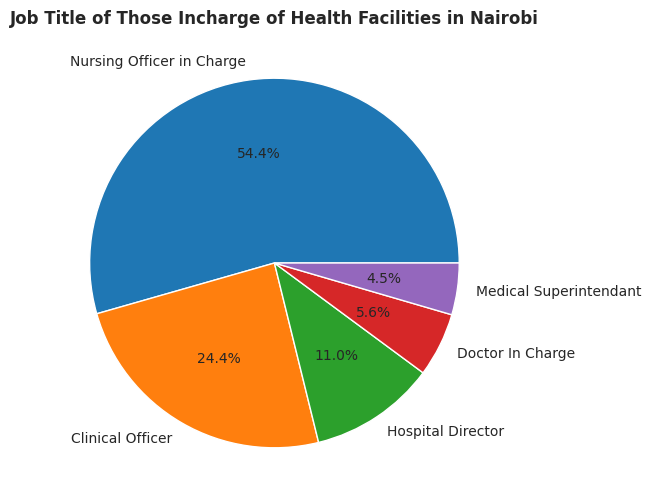

In [45]:
plt.figure(figsize=(6, 6))
plt.pie(job_title_incharge, labels=job_title_incharge.index, autopct="%1.1f%%");
plt.title("Job Title of Those Incharge of Health Facilities in Nairobi", fontweight="bold");

As we can see most of the persons incharge of health facilities in Nairobi have the title `Nursing Officer in Charge`.

What about ownership? Who owns most of the health facilities in Nairobi?

In [46]:
facilities_ownership = (
   health_facilities_df_nairobi["Owner"].value_counts().sort_values(ascending=False)
)
facilities_ownership_df = pd.DataFrame(facilities_ownership)
facilities_ownership_df = facilities_ownership_df.reset_index()
facilities_ownership_df

,Owner,count
0,Private Enterprise (Institution),219
1,Private Practice - General Practitioner,161
2,Non-Governmental Organizations,116
3,Private Practice - Unspecified,63
4,Local Authority,58
5,Ministry of Health,56
6,Kenya Episcopal Conference-Catholic Secretariat,49
7,Private Practice - Nurse / Midwife,40
8,Private Practice - Clinical Officer,39
9,Private Practice - Medical Specialist,34


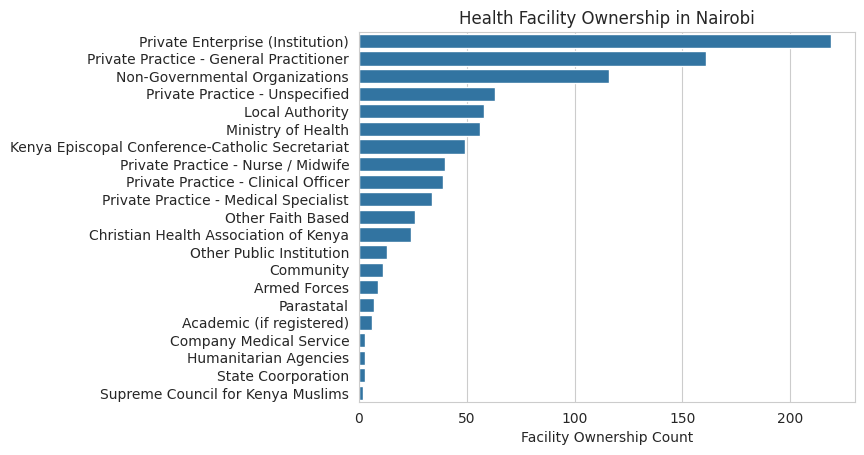

In [47]:
ax = sns.barplot(
    data=facilities_ownership_df,
    x= "count",
    y="Owner",
)
ax.set_title("Health Facility Ownership in Nairobi");
plt.xlabel("Facility Ownership Count");
plt.ylabel("");

From the above we can see that most health facilities in Nairobi are privately owned with the government only starting to come in on ownership at around 5th place with the `Local Authority` label.

## Feature Engineering

Here we determine the ratio of various aspects of the health facilities in Nairobi that affect accessibility.

We can start by combining the data in `health_facilities_df_nairobi` and `population_density_by_subcounty_df`.    
This will help us determine the number of people each sub-county in Nairobi is expected to serve.

In [48]:
nairobi_facilities_count.sort_values(by="Sub County", ascending=True, inplace=True)
nairobi_facilities_count

,Sub County,Number of Facilities,Latitude,Longitude
0,Dagoretti,229,-1.283451,36.724673
1,Embakasi,351,-1.307610,36.934177
2,Kamukunji,58,-1.277867,36.861705
3,Kasarani,55,-1.218500,36.902231
4,Kibra,44,-1.306289,36.780783
5,Langata,40,-1.370875,36.818415
6,Makadara,40,-1.295219,36.871861
7,Mathare,29,-1.265011,36.849570
8,Roysambu,27,-1.218840,36.886739
9,Ruaraka,27,-1.242994,36.875619


In [49]:
# Nairobi population data per sub-county
nairobi_population_df = population_density_by_subcounty_df[385:]
nairobi_population_df["Sub County"] = (
    nairobi_population_df["Sub County"].str.replace(".", "").str.replace(" ", "").str.replace("'","")
)
nairobi_population_df.sort_values(by="Sub County", ascending=True, inplace=True)
nairobi_population_df

,Sub County,Population,Land Area (Sq. Km),Population Density (No. per Sq. Km)
385,Dagoretti,434208,29.1,14908
386,Embakasi,988808,86.3,11460
387,Kamukunji,268276,10.5,25455
388,Kasarani,780656,86.2,9058
389,Kibra,185777,12.1,15311
390,Langata,197489,216.8,911
391,Makadara,189536,11.7,16150
392,Mathare,206564,3.0,68941
393,Njiru,626482,129.9,4821
394,Starehe,210423,20.6,10205


In [50]:
nairobi_facility_population_df = pd.merge(nairobi_facilities_count,
                                          nairobi_population_df,
                                          on='Sub County',
                                          how="left")
nairobi_facility_population_df = nairobi_facility_population_df.dropna()
nairobi_facility_population_df["Population"] = nairobi_facility_population_df["Population"].astype(int)
nairobi_facility_population_df

,Sub County,Number of Facilities,Latitude,Longitude,Population,Land Area (Sq. Km),Population Density (No. per Sq. Km)
0,Dagoretti,229,-1.283451,36.724673,434208,29.1,14908.0
1,Embakasi,351,-1.307610,36.934177,988808,86.3,11460.0
2,Kamukunji,58,-1.277867,36.861705,268276,10.5,25455.0
3,Kasarani,55,-1.218500,36.902231,780656,86.2,9058.0
4,Kibra,44,-1.306289,36.780783,185777,12.1,15311.0
5,Langata,40,-1.370875,36.818415,197489,216.8,911.0
6,Makadara,40,-1.295219,36.871861,189536,11.7,16150.0
7,Mathare,29,-1.265011,36.849570,206564,3.0,68941.0
10,Starehe,26,-1.297481,36.832560,210423,20.6,10205.0
11,Westlands,16,-1.246528,36.786076,308854,97.5,3167.0


## Hypothesis Testing

Our hypothesis when we started on the analysis was: **Regions with higher density have a greater number of healthcare facilities compared to regions with lower population density.**

Rationale: **Denser populations might drive a higher demand for healthcare services, leading to more health facilities.**

 According to a report by the Kenyan government, https://www.countdown2030.org/wp-content/uploads/2023/02/Infrastructure-Policy.pdf:    
 *The average national health
facility density is 2.2 per 10,000 population which is slightly
above the target of 2 per 10,000 population. (2018, KHFA).
However, it is noted that there are geographical disparities with
33 (70%) counties having health facility densities of 2 per 10,000
population and above apart from Nandi, Kwale, Uasin Gishu,
Nairobi, Busia, Bomet, Trans Nzoia, Kakamega, Narok, Vihiga,
Wajir, Kisii, Bungoma and Mandera Counties with facility density
of below 2 per 10,000 population*.  

By knowing this we can try determining whether most facilities in Nairobi meet the minimum health facility density of 2 per 10,000 population.

In [51]:
nairobi_facility_population_df["Facilities per 10,000 People"] = (nairobi_facility_population_df["Number of Facilities"] / nairobi_facility_population_df["Population"]) * 10000
nairobi_facility_population_df

,Sub County,Number of Facilities,Latitude,Longitude,Population,Land Area (Sq. Km),Population Density (No. per Sq. Km),"Facilities per 10,000 People"
0,Dagoretti,229,-1.283451,36.724673,434208,29.1,14908.0,5.273970
1,Embakasi,351,-1.307610,36.934177,988808,86.3,11460.0,3.549729
2,Kamukunji,58,-1.277867,36.861705,268276,10.5,25455.0,2.161953
3,Kasarani,55,-1.218500,36.902231,780656,86.2,9058.0,0.704536
4,Kibra,44,-1.306289,36.780783,185777,12.1,15311.0,2.368431
5,Langata,40,-1.370875,36.818415,197489,216.8,911.0,2.025429
6,Makadara,40,-1.295219,36.871861,189536,11.7,16150.0,2.110417
7,Mathare,29,-1.265011,36.849570,206564,3.0,68941.0,1.403923
10,Starehe,26,-1.297481,36.832560,210423,20.6,10205.0,1.235606
11,Westlands,16,-1.246528,36.786076,308854,97.5,3167.0,0.518044


From the above data we can determine that most of the counties in Nairobi meet the threshhold health facility density of 2 per 10,000 people in the population.

Next we determine the correlation between population density and the number of health facilities in a sub-county.

In [52]:
correlation_matrix = nairobi_facility_population_df.corr(numeric_only=True)
correlation = correlation_matrix.loc['Population', 'Number of Facilities']
print(f'The Correlation of population and number of health facilities in Nairobi sub-counties is: {correlation}')

The Correlation of population and number of health facilities in Nairobi sub-counties is: 0.7479211859013943


We can see a correlation coefficient of 0.747 between number of facilities and population which indicates a strong positive correlation between population and health facilities.
This means that as the population increases, the number of health facilities also tends to increase.

To better visualize this information. Here is a linear regression representation:

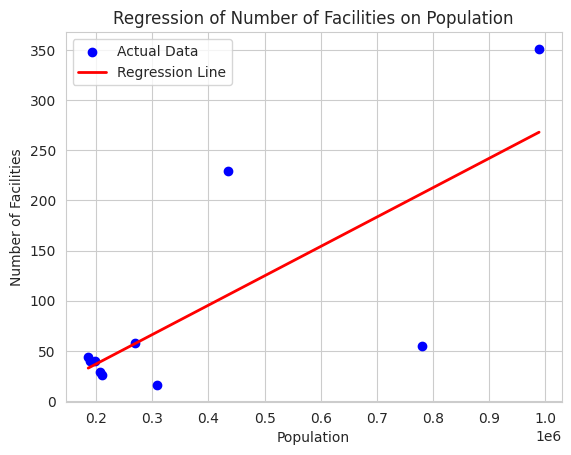

In [53]:
population = nairobi_facility_population_df["Population"]
facilities = nairobi_facility_population_df["Number of Facilities"]

# Reshape data for scikit-learn
population = [[x] for x in population]  # Convert to 2D array

# Create and fit the linear regression model
model = LinearRegression()
model.fit(population, facilities)

# Generate predictions for the entire population range
population_range = [[x] for x in range(min(population)[0], max(population)[0] + 1, 1000)]  # Adjusted step size
predicted_facilities = model.predict(population_range)

# Plot the scatter plot and regression line
plt.scatter(population, facilities, color='blue', label='Actual Data')
plt.plot(population_range, predicted_facilities, color='red', linewidth=2, label='Regression Line')

plt.xlabel('Population')
plt.ylabel('Number of Facilities')
plt.title('Regression of Number of Facilities on Population')
plt.legend()
plt.grid(True)
plt.show()

## Results and Interpretation

With this we have established that:


1.   As the population of a sub-county increases in Nairobi, the number of health facilities increases.
2.   Most sub-counties in Nairobi meet the minimun health facility standards suggested by the kenyan government in 2020.

## Conclusion

The findings of this study suggest that healthcare is more accessible in more densely populated areas, likely due to the higher concentration of privately-owned healthcare facilities in these areas. This may lead to health disparities, as patients living in rural or underserved areas may have difficulty accessing necessary healthcare services.

### Implications:

- Policymakers should consider implementing policies to increase the density of health facilities in underserved areas, such as financial incentives for healthcare providers to locate in these areas or zoning regulations that encourage the development of new facilities.
- Healthcare providers should be aware of the challenges faced by patients living in areas with limited access to healthcare and take steps to make their services more accessible, such as offering telehealth services or providing transportation assistance.
- Community organizations can play a role in improving accessibility of healthcare by providing education and outreach services, as well as advocating for policies that support increased access to care.

### Further Research:

- Future research should explore the specific factors that contribute to the relationship between health facility density and accessibility of healthcare.
- Additional research is also needed to examine the impact of healthcare accessibility on health outcomes and health disparities.



## Limitations
* Data for some sub-counties was unavailable due to issues with how fields were named.
* Due to the little amount of time we had to prepare, we could not go more indepth.

## End Credits

This is a notebook by: Kennedy, Paul, Pauline and Antony 👌